In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas
from rasterio import features

import datacube 
import xarray as xr
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking

# Connect to current collection and collection upgrade databases
dc = datacube.Datacube()

import sys
sys.path.append('../10_Scripts')
import DEAPlotting, SpatialTools, DEADataHandling

In [2]:
with rasterio.open('validation/raw_data/LiDAR/Inland/NSW Government/DEMs/cawndilla_5m_dem.tif') as dataset:
    
    # Get profile
    lidar_profile = dataset.profile
    
    # Read the dataset as a ndarray.
    lidar_dem = dataset.read().squeeze()
    
    # Set water areas to NaN
    lidar_dem[lidar_dem < 53] = 53

# Load shapefile and reproject to LiDAR CRS
polygon_gdf = geopandas.read_file('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/raw_data/LiDAR/Inland/Dam_levels/cawndilla/cawdilla_extent.shp')
polygon_gdf = polygon_gdf.to_crs(crs=lidar_profile['crs'])

# Identify all geometry objects in shapefile
shapes = [(shape, n) for n, shape in enumerate(polygon_gdf.geometry)]

# Generate mask
lidar_mask = features.rasterize(shapes, out_shape=lidar_dem.shape,
                                fill=np.nan, transform=lidar_profile['transform'],
                                all_touched=True, dtype=np.float)

# Apply mask
lidar_dem[~np.isfinite(lidar_mask)] = np.nan

# Export
kwargs = {'driver': 'GTiff',
         'width': lidar_profile['width'],
         'height': lidar_profile['height'],
         'count': 1,
         'dtype': rasterio.float32,
         'crs': lidar_profile['crs'],
         'transform': lidar_profile['transform'],
         'nodata': -9999}

with rasterio.open(f'validation/menindee_lidar.tif', 'w', **kwargs) as target:
    target.write_band(1, lidar_dem)
    

## Load water level data

In [3]:
test = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/raw_data/LiDAR/Inland/Dam_levels/cawndilla/425023.csv', 
            skiprows=5, usecols=[0, 1, 2, 3, 5], names=['date', 'level_m', 'level_m_acc', 'volume_ML', 'perc_full'])

test['date'] = test.apply(lambda x: str(x.date)[9:], axis=1)

# Covert datetimes
test['date'] = pd.to_datetime(test['date'], format='%d/%m/%Y')
test = test.set_index(pd.DatetimeIndex(test['date']))
test.drop(['date'], axis=1, inplace=True)
test.head()

test.loc[test.level_m < 53,'level_m'] = 53


In [64]:
test = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/raw_data/LiDAR/Inland/Dam_levels/keepit_csv.w00077.20190213091322.419041.csv', 
            skiprows=10, usecols=[0, 1], names=['date', 'level_m'])

test['date'] = test.apply(lambda x: str(x.date)[0:10], axis=1)
test = test.set_index(pd.DatetimeIndex(test['date']))
test.drop(['date'], axis=1, inplace=True)
test.head()

,level_m
date,
1986-01-01,329.091
1986-01-02,329.042
1986-01-03,328.992
1986-01-04,328.939
1986-01-05,328.887


In [3]:
import geopandas as gpd
from rasterio import features

# Load shapefile and reproject 
polygon_gdf = gpd.read_file('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/raw_data/LiDAR/Inland/Dam_levels/cawndilla/cawdilla_extent.shp')
polygon_gdf


# # Identify all geometry objects in shapefile
# shapes = [(shape, n) for n, shape in enumerate(polygon_gdf.geometry)]
# shapes

# # Generate mask
# lidar_mask = features.rasterize(shapes, out_shape=lidar_dem.shape,
#                                 fill=np.nan, transform=lidar_profile['transform'],
#                                 all_touched=True, dtype=np.float)

[(<shapely.geometry.polygon.Polygon at 0x7fb48b85b470>, 0)]

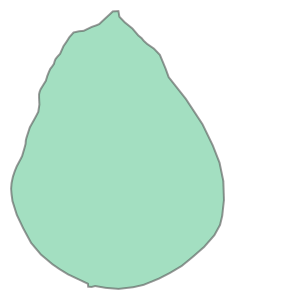

In [4]:
import datacube
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

dc = datacube.Datacube(app='Simple example')

# Set up analysis data query
lat_point, lon_point, buffer = -33.9654850031, 151.200615137, 4000
x, y = geometry.point(lon_point, lat_point, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),         
         'crs': 'EPSG:3577',
         'time': ('1988-01-01', '1989-01-01')}

# Load dta
data = dc.load(product = "ls5_nbart_albers",
            group_by = 'solar_day', 
            **query)

In [32]:
import fiona

poly_path = '/g/data/r78/SA_mound_springs/Big_Blythe_small.shp'

with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

Geometry(POLYGON ((950485.633077399 -3572461.8843384,950682.915164678 -3572241.1248468,950951.242380217 -3572181.78889728,951165.428338639 -3572161.47200193,951548.101563207 -3571975.75448359,951765.093823254 -3571900.82029688,951906.821746998 -3571840.05253277,952064.171714787 -3571691.10374901,952553.934297303 -3571237.01534054,952817.347404785 -3571223.51554341,952864.191991563 -3571492.70369897,953116.855260971 -3571755.31456821,953480.98761332 -3572049.95038817,953761.985674858 -3572380.82117788,953920.678788861 -3572511.20682513,954025.417199616 -3572640.12573978,954185.896665453 -3572787.36692824,954505.586042551 -3573007.78518171,954791.397177967 -3573306.21744458,955063.62942593 -3573962.68891735,955210.506120786 -3574369.65181063,956028.055529819 -3575404.49164044,956820.284715002 -3576610.27221546,957309.06505747 -3577618.50776047,957630.40869521 -3578440.17782754,957810.720611278 -3579313.83259047,957840.55256774 -3580215.62279962,957756.90868897 -3580969.82027682,957653.85

In [33]:
geom

Geometry(POLYGON ((136.049897345077 -28.0585417207972,136.052532380781 -28.058383175232,136.053849898633 -28.0572205006082,136.054448770384 -28.056269212017,136.054867980609 -28.0549479638975,136.055167416485 -28.0537324012863,136.055646513886 -28.0510898264579,136.055706401061 -28.0489228666359,136.063192297947 -28.0463858825771,136.065348236251 -28.0460687553616,136.065348236251 -28.0474429665416,136.063371959473 -28.0502970413447,136.061635231395 -28.0541023565794,136.059599067442 -28.0572205006082,136.058042000889 -28.0592815970098,136.056245385636 -28.0607084867523,136.054568544734 -28.0612369596276,136.05241260643 -28.0609198762142,136.050855539878 -28.0600743158719,136.050077006602 -28.0593344451158,136.049897345077 -28.0585417207972)), GEOGCS["GCS_WGS_1984",DATUM["WGS_1984",SPHEROID["WGS_84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295],AUTHORITY["EPSG","4326"]])

In [54]:
from datacube.utils import geometry
import shapely.geometry


polygon_gdf = gpd.read_file('/g/data/r78/SA_mound_springs/Big_Blythe_small.shp')
polygon_gdf

selected_poly = polygon_gdf.iloc[0]


geom = geometry.Geometry(shapely.geometry.mapping(selected_poly.geometry), crs=polygon_gdf.crs)
geom


geometry.CRS(polygon_gdf.crs)


# geometry.CRS(shapes.crs_wkt)

# # # geometry.Geometry(shapely.geometry.mapping(polygon_gdf.geometry[0]), crs='EPSG:3577')


# query = {'geopolygon': geom,
#          'time': ('1988-01-01', '1989-01-01')
#          }

# data = dc.load(product = "ls5_nbart_albers",
#             group_by = 'solar_day', 
#             **query)

TypeError: unhashable type: 'dict'

In [48]:
polygon_gdf.crs

{'init': 'epsg:4326'}

## Set query region and time

In [1]:
# # Centre point of spatial query
# lat, lon = -32.47, 142.229185
# time_period = ('1987-06-15', '2019-04-01')

# # Set up query
# query = {'lon': (lon - 0.06, lon + 0.065),
#          'lat': (lat - 0.06, lat + 0.065),
#          'time': time_period}


# Centre point of spatial query
lat, lon = -30.8456, 150.5189
time_period = ('1987-06-15', '2019-04-01')

# Set up query
query = {'lon': (lon - 0.055, lon + 0.055),
         'lat': (lat - 0.065, lat + 0.065),
         'time': time_period}

# Preview spatial query
DEAPlotting.display_map(x=query['lon'], y=query['lat'], crs='EPSG:4326')


NameError: name 'DEAPlotting' is not defined

## Load Landsat data

In [86]:
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query,
                                               sensors=['ls5', 'ls7', 'ls8'],
                                               bands_of_interest=['green', 'nir', 'swir1'],
                                               masked_prop=0.97, 
                                               mask_pixel_quality=True,
                                               mask_invalid_data=True,
                                               ls7_slc_off=False)

# Compute NDWI and MNDWI 
landsat_ds['NDWI'] = (landsat_ds.green - landsat_ds.nir) / (landsat_ds.green + landsat_ds.nir)
landsat_ds['MNDWI'] = (landsat_ds.green - landsat_ds.swir1) / (landsat_ds.green + landsat_ds.swir1)

Loading ls5
    Loading 229 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 43 filtered ls7 timesteps
Loading ls8
    Loading 78 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [28]:
polygon_gdf = polygon_gdf.to_crs(epsg=landsat_ds.crs.epsg)

# # Identify all geometry objects in shapefile
shapes = [(shape, n) for n, shape in enumerate(polygon_gdf.geometry)]

# Generate mask
xarray_mask = features.rasterize(shapes, out_shape=landsat_ds.NDWI.shape[1:],
                                 fill=np.nan, transform=landsat_ds.affine,
                                 all_touched=True, dtype=np.float)

# Apply mask
landsat_ds = landsat_ds.where(np.expand_dims(np.isfinite(xarray_mask), axis=0))

In [21]:
# DEAPlotting.rgb(landsat_ds, bands=['swir1', 'nir', 'green'], col='time')

In [87]:
subset = test.loc[pd.to_datetime(landsat_ds.time.values.astype('datetime64[D]'))]
landsat_ds['level_m'] = xr.DataArray(subset.level_m, [('time', landsat_ds.time)])
landsat_ds['level_m_var'] = xr.DataArray(subset.level_m, [('time', landsat_ds.time)])
landsat_ds = landsat_ds.sortby('level_m')
landsat_ds = landsat_ds.swap_dims({'time':'level_m'})

landsat_ds = landsat_ds.sel(level_m=~landsat_ds.level_m.isnull())

In [88]:
rolling_mndwi = landsat_ds.MNDWI.rolling(level_m=10, min_periods=1, center=True).median(dim='level_m')

In [103]:
# index_thresh = 0

# custom_attrs = {'level_m': rolling_mndwi.level_m.values.tolist(),
#                 'date': [str(i)[0:10] for i in landsat_ds.time.values]}
# custom_attrs_dtypes = {'level_m': 'float', 'date': 'str'}

# # Extract contours with custom attribute fields:
# contour_gdf = SpatialTools.contour_extract(z_values=[index_thresh],
#                                            ds_array=rolling_mndwi,
#                                            ds_crs='epsg:3577',
#                                            ds_affine=landsat_ds.affine,
#                                            output_shp=f'validation/keepit_nidem.shp',
#                                            attribute_data=custom_attrs,
#                                            attribute_dtypes=custom_attrs_dtypes,
#                                            min_vertices=5,
#                                            dim='level_m',
#                                            verbose=False)

# # Extract vertex coordinates and heights from geopandas
# def contours_to_arrays(gdf, col):

#     coords_zvals = []

#     for i in range(1, len(gdf)):

#         val = gdf.iloc[i][col]

#         try:
#             coords = np.concatenate([np.vstack(x.coords.xy).T for x in gdf.iloc[i].geometry])

#         except:
#             coords = np.vstack(gdf.iloc[i].geometry.coords.xy).T

#         coords_zvals.append(np.column_stack((coords, np.full(np.shape(coords)[0], fill_value=val))))

#     return np.concatenate(coords_zvals)


# # Extract x, y and z points for interpolation
# all_contours = contours_to_arrays(gdf=contour_gdf, col='level_m')
# points_xy = all_contours[:, [1, 0]]
# values_elev = all_contours[:, 2]

# # # Create grid to interpolate into
# x_size, _, upleft_x, _, y_size, upleft_y =  landsat_ds.geobox.transform[0:6]
# xcols = len(landsat_ds.x)
# yrows = len(landsat_ds.y)
# bottomright_x = upleft_x + (x_size * xcols)
# bottomright_y = upleft_y + (y_size * yrows)
# grid_y, grid_x = np.mgrid[upleft_y:bottomright_y:1j * yrows, upleft_x:bottomright_x:1j * xcols]

# # Interpolate x, y and z values using linear/TIN interpolation
# import scipy
out = scipy.interpolate.griddata(points_xy, values_elev, (grid_y, grid_x), method='linear')

# Remove pixels that are never or always wet
out[~(rolling_mndwi > index_thresh).max(dim='level_m').values] = np.nan
out[((rolling_mndwi > index_thresh).sum(dim='level_m') == len(rolling_mndwi.level_m)).values] = np.nan

# Export
kwargs = {'driver': 'GTiff',
         'width': xcols,
         'height': yrows,
         'count': 1,
         'dtype': rasterio.float64,
         'crs': 'EPSG:3577',
         'transform': landsat_ds.geobox.transform,
         'nodata': -9999}

with rasterio.open(f'validation/keepit_nidem_ndwi.tif', 'w', **kwargs) as target:
    target.write_band(1, out)



350

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less


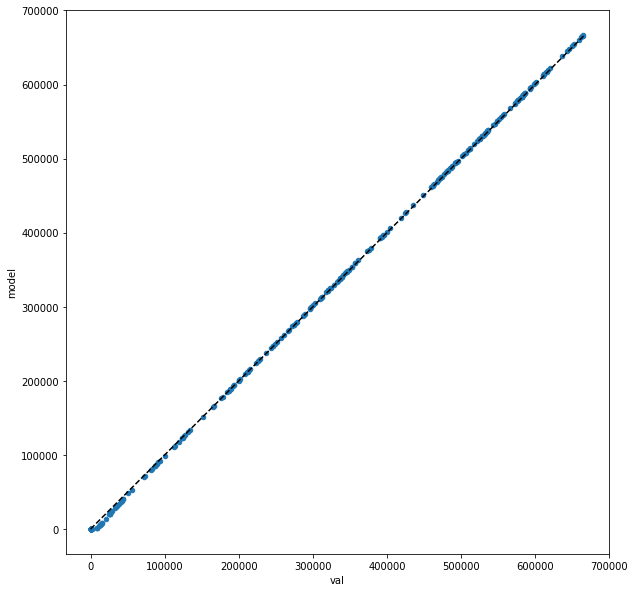

In [44]:
volumes_model = []
volumes_val = []

for index, row in test[test.level_m < rolling_mndwi.level_m.max().item()].sample(300).iterrows():
    
    waterlevel_diff = (np.full(out.shape, row.level_m) - out)
    waterlevel_diff[waterlevel_diff < 0] = np.nan
    volume_model = np.nansum(((waterlevel_diff * (25 * 25)) * 0.001))
    volume_val = row.volume_ML
    
    
    waterlevel_diff = (np.full(lidar_dem.shape, row.level_m) - lidar_dem)
    waterlevel_diff[waterlevel_diff < 0] = np.nan
    volume_lidar = np.nansum(((waterlevel_diff * (5 * 5)) * 0.001))        
    
    volumes_model.append(volume_model)
#     volumes_val.append(volume_val)   
    volumes_val.append(volume_lidar)   
    
vol_df = pd.DataFrame(data = {'model': volumes_model, 'val': volumes_val})

dist_lim = vol_df.max(axis=0).max()
vol_df.plot.scatter(x='val', y='model', figsize=(10, 10))
plt.gca().set_aspect('equal')
plt.plot(np.linspace(0, dist_lim), np.linspace(0, dist_lim), 'black', linestyle='dashed')

In [91]:
len(volumes_val)

200

In [88]:
np.nansum(((waterlevel_diff * (5 * 5)) * 0.001))

376367.1529664499

In [48]:
# vol_df.corr()

In [26]:
rolling_conf = landsat_ds.NDWI.rolling(level_m=10, min_periods=1, center=True).std(dim='level_m')



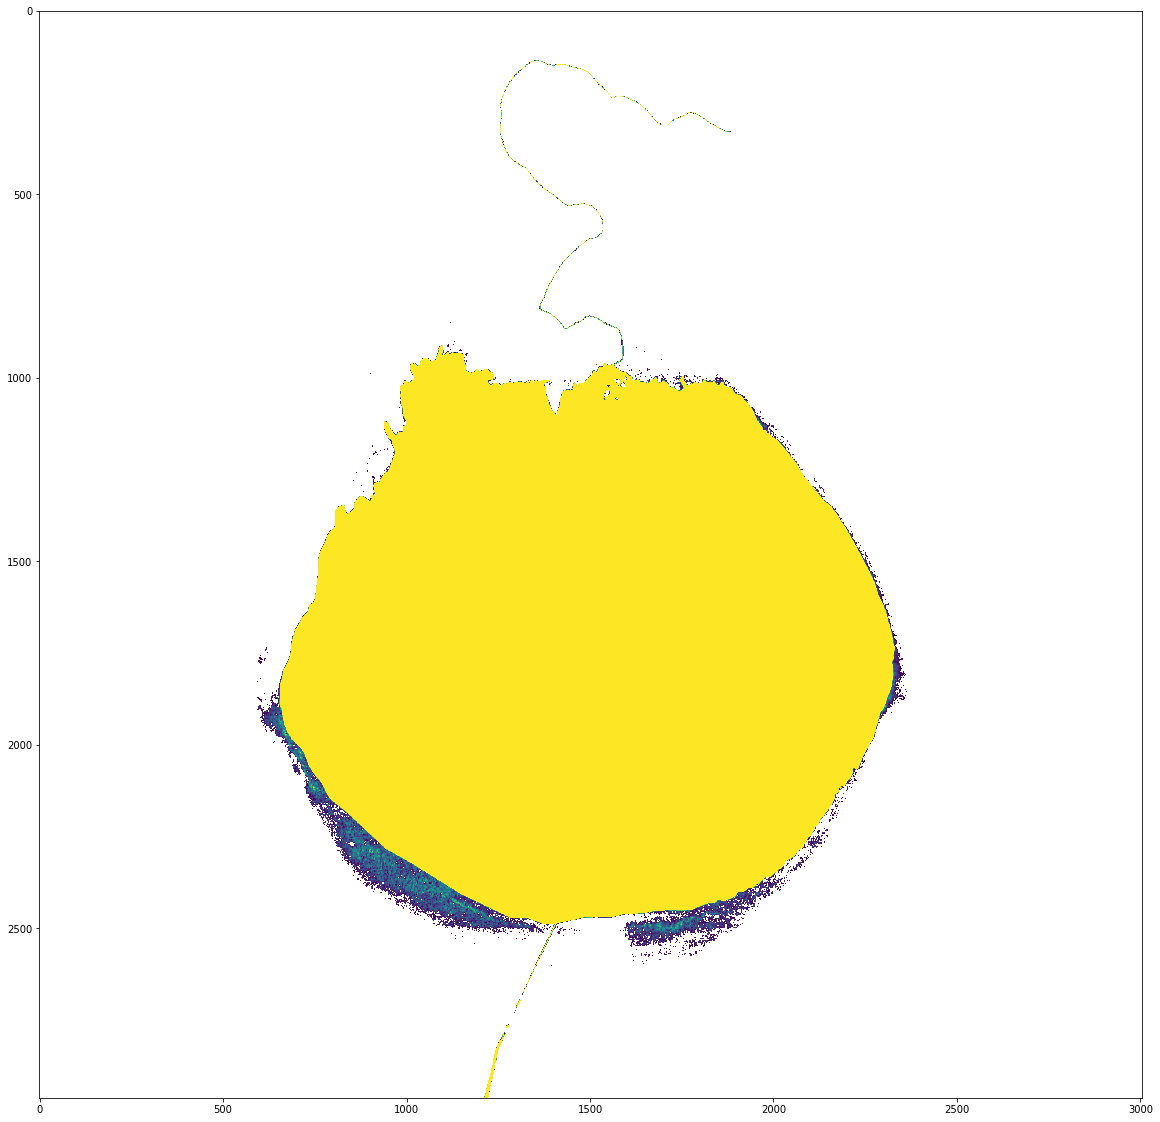

In [83]:
plt.subplots(1, 1, figsize=(20,20))
plt.imshow(waterlevel_diff)

In [ ]:
(rolling_conf.mean(dim='level_m') > 0.14).plot(cmap='RdYlBu_r', size=10, aspect=1)

21975.497380066063

In [ ]:
landsat_ds.affine

In [ ]:
custom_attrs = {'date': subset.index.astype('str').tolist(),
                'level': subset.level_m.tolist()}
custom_attrs_dtypes = {'date': 'str', 'level': 'float'}

# Extract contours with custom attribute fields:
contour_gdf = SpatialTools.contour_extract(z_values=subset.level_m.tolist(),
                                           ds_array=lidar_dem,
                                           ds_crs='epsg:28354',
                                           ds_affine=dataset.transform,
                                           output_shp=f'validation/test.shp',
                                           attribute_data=custom_attrs,
                                           attribute_dtypes=custom_attrs_dtypes,
                                           min_vertices=50,
                                           verbose=False)

In [ ]:
custom_attrs = {'date': [str(i)[0:10] for i in landsat_ds.time.values]}
custom_attrs_dtypes = {'date': 'str'}

# Extract contours with custom attribute fields:
contour_gdf = SpatialTools.contour_extract(z_values=[0.2],
                                           ds_array=landsat_ds.MNDWI,
                                           ds_crs='epsg:3577',
                                           ds_affine=landsat_ds.affine,
                                           output_shp=f'validation/landsat.shp',
                                           attribute_data=custom_attrs,
                                           attribute_dtypes=custom_attrs_dtypes,
                                           min_vertices=50,
                                           verbose=False)